# Time series analysis
Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. In this project several models were developed in order to predict future values based on previously observed values. In doing so, we assume that what happened in the past is a good starting point for predicting what will happen in the future. In total, 5 models were developed but only 4, polynomial regression, ARIMA, a Recurrent Neural Network (RNN) and a Long Short-Term Network (LSTM) provided acceptable results. 

In [3]:
%load_ext autoreload
%autoreload 2

from src.__init__ import *

The models were developed using data from 2004-08-19 to 2019-01-18. The data consists of the asset price at the start of the day, highest and lowest price reached that day, and closing daily price. The analysis was done using the closing daily price. 

        Index       Open       High        Low      Close
0  2004-08-19  50.050049  52.082081  48.028027  50.220219
1  2004-08-20  50.555557  54.594593  50.300301  54.209209
2  2004-08-23  55.430431  56.796795  54.579578  54.754753
3  2004-08-24  55.675674  55.855854  51.836838  52.487488
4  2004-08-25  52.532532  54.054054  51.991993  53.053055


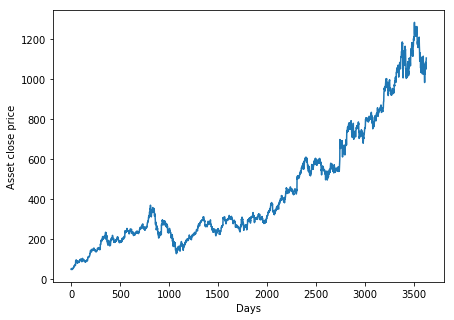

In [23]:
# Reading file and inspecting it
seriesFull = pd.read_csv('../data/raw/example.csv', header=0) 
print(seriesFull.head())

series = seriesFull[['Index','Close']]
plt.rcParams["figure.figsize"] = (7,5)
plt.plot(series['Close'])
plt.xlabel("Days")
plt.ylabel("Asset close price")
plt.show()

The goal of the analysis was to predict the asset price $N$ days ahead (steps_ahead) using asset prices $M$ days in the past (fit_range). The metric used to quantify the accuracy of the predictions was the root mean square error (RMSE). All model parameters were optimized on a rolling basis using $M$ days in the past to predict $N$ days ahead. As such all the models predict a rolling estimate over the whole time range but the first $M$ days.  Since for the ARIMA, polynomial and SVM models, the model is optimized without "seeing" the future (price asset $N$ days ahead), their RMSE is calculated over the whole time range and it represents the out-of-the-bag error of the model. For the RNN and LSTM models, the whole time range is randomly separated into train (70%)and test (30%) data. The RMSE is calculated on the test data only.

**Comment about the code:** The algorithms used in our analysis employ either native Scikit-Learn base estimator classes or have been written based on them. Two of the algorithms
employed (RNN and LSTM) used the TensorFlow framework, and therefore two new
classes, RNNClassifier and LSTMClassifier (Scikit-Learn compatible) were written. The strategies discussed here were coded using unique classes that rely heavily on parent inheritance.

In [8]:
steps_ahead = 30 #N
fit_range = 50   #M

## ARIMA model
The **ARIMA** (AutoRegressive Integrated Moving Average) model has hyper-parameters (**p,d,q**) that represent different corrections or features of the model:
* Autogression: Relationship between an observation and a number of lag observations (**p**).
* Integrated: To make the time series stationary and remove trend and seasonal structures, the model subtracts an observation from an observation at a previous time step. The number of times that the raw observations are differenced (subtracted) is **d**. 
* Moving average: The model uses the dependency between an observation and a residual error with a moving average (of length **q**)

It is possible to obtain insight into the autoregression parameter **p** by plotting the Autocorrelation (ACF) and partial (pACF) autocorrelation functions:

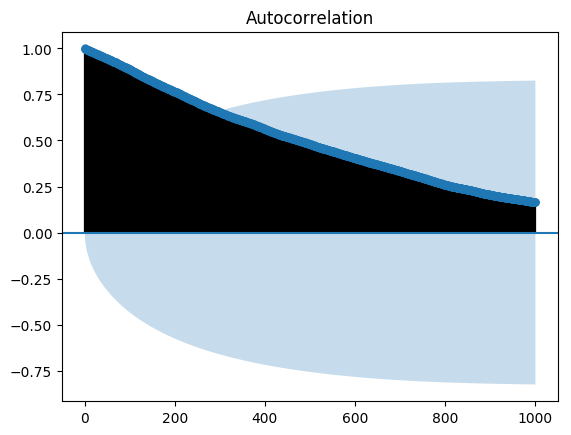

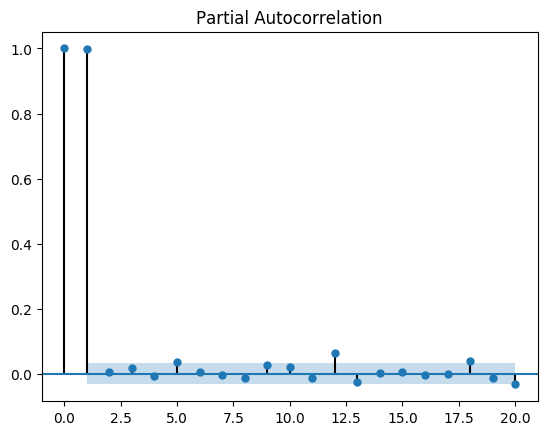

In [8]:
# Finding the Autocorrelation (ACF) and partial (pACF) Autocorrelation functions 
tsaplots.plot_acf(series['Close'], lags = 1000)
tsaplots.plot_pacf(series['Close'], lags = 20)
plt.show()

This suggests that there is a quite a bit of autoregression up to very large lags but mostly it can be explained by **p=1**. The optimal ARIMA parameters (**p,d,q**) can be found by iterating over the different combinations:

In [17]:
p = d = q = range(0, 3)
parameters = list(itertools.product(p, d, q))
model_selection = ['ARIMA', parameters]
bestParam, bestRMSE, gridResults = gridSearch(series, model_selection, steps_ahead, fit_range, fastRMSE=False, numInstances=200) 

Method: ARIMA - Param: (0, 0, 0) - RMSE: 50.3918
Method: ARIMA - Param: (0, 0, 1) - RMSE: 50.2967
Method: ARIMA - Param: (0, 1, 0) - RMSE: 53.2371
Method: ARIMA - Param: (0, 1, 1) - RMSE: 53.3756
Method: ARIMA - Param: (0, 1, 2) - RMSE: 53.7979
Method: ARIMA - Param: (0, 2, 0) - RMSE: 334.8272
Method: ARIMA - Param: (0, 2, 1) - RMSE: 139.2466
Method: ARIMA - Param: (1, 0, 0) - RMSE: 44.6161
Method: ARIMA - Param: (1, 1, 0) - RMSE: 54.5148
Method: ARIMA - Param: (1, 2, 0) - RMSE: 268.3600
Method: ARIMA - Param: (2, 1, 0) - RMSE: 53.8237
Best parameters for method ARIMA
Param: (1, 0, 0) - RMSE: 44.6161


The lowest RMSE (44.62)  corresponds to ARIMA(**1,0,0**). However, even the optimized model is not a great estimation since ARIMA(0,0,0) is just slightly worse. 

## Polynomial with ridge regularization
For simplicity this model uses a polynomial of order 3. For every data point, the parameters of the polynomial are optimized using $50$ days into the past.  The regression cost function uses a quadratic penalty (ridge) with weight **$\alpha$**. This coefficient is a hyper-parameter that was optimized:

In [16]:
parameters = range(580, 620, 4)
model_selection = ['poly', parameters]
bestParam, bestRMSE, gridResults = gridSearch(series, model_selection, steps_ahead, fit_range, fastRMSE=False, numInstances=200) 

Method: poly - Param: 580 - RMSE: 43.5808
Method: poly - Param: 584 - RMSE: 43.5778
Method: poly - Param: 588 - RMSE: 43.5754
Method: poly - Param: 592 - RMSE: 43.5735
Method: poly - Param: 596 - RMSE: 43.5720
Method: poly - Param: 600 - RMSE: 43.5709
Method: poly - Param: 604 - RMSE: 43.5703
Method: poly - Param: 608 - RMSE: 43.5701
Method: poly - Param: 612 - RMSE: 43.5704
Method: poly - Param: 616 - RMSE: 43.5710
Best parameters for method poly
Param: 608 - RMSE: 43.5701


The RMSE is slightly better than the ARIMA model but it is still not great. The lowest RMSE (43.57) corresponds to $\alpha=608$.

## SVM regression
For simplicity this model uses a polynomial of order 3. The support vector regression model has hyper-parameters **C** and $\epsilon$ representing the strength of the regularization and width of the margin, respectively. 

In [14]:
parameters = [[10**np.random.uniform(0,2.5), np.random.uniform(0.01,0.1)] for i in range(0,100)]
model_selection = ['SVM', parameters]
bestParam, bestRMSE, gridResults = gridSearch(series, model_selection, steps_ahead, fit_range, 
                                              fastRMSE = True, numInstances=200) 
grid = pd.DataFrame(gridResults.Param.values.tolist(), columns=['C','epsilon'])
grid['RMSE'] = gridResults['RMSE']

Method: SVM - Param: [1.440560504635875, 0.06650627453623208] - RMSE: 498.7121
Method: SVM - Param: [3.7891617208520905, 0.08967236597383675] - RMSE: 406.4787
Method: SVM - Param: [5.13719408098369, 0.020676711593975973] - RMSE: 341.0009
Method: SVM - Param: [253.3555614939664, 0.06156086252046523] - RMSE: 205.7539
Method: SVM - Param: [65.31810170418956, 0.09350412721023897] - RMSE: 155.1689
Method: SVM - Param: [49.11738512465951, 0.06511952774299071] - RMSE: 164.7664
Method: SVM - Param: [31.400209705373214, 0.07109275197796715] - RMSE: 154.8365
Method: SVM - Param: [23.692833770321467, 0.031896392115284805] - RMSE: 135.3943
Method: SVM - Param: [92.38949706316791, 0.07455168370009214] - RMSE: 150.1374
Method: SVM - Param: [3.7911416095663797, 0.07836212927670592] - RMSE: 377.9335
Method: SVM - Param: [1.2241768130023776, 0.06197801248392666] - RMSE: 488.7911
Method: SVM - Param: [5.367269566770042, 0.09546915952170885] - RMSE: 363.0664
Method: SVM - Param: [132.722601796458, 0.0771

The RMSE is pretty high for all hyper-parameter combinations used. Furthermore, there is not a large dependence on **C** and $\epsilon$:

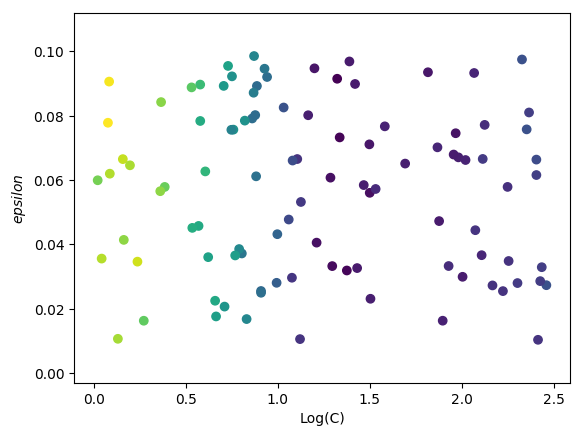

In [15]:
plt.scatter(x = np.log10(grid['C']), y = grid['epsilon'], c= grid['RMSE'])
plt.xlabel('Log(C)')
plt.ylabel('$epsilon$')
plt.show()

Since the RMSE is significantly larger than for the other optimized models, this model was abandoned. 

## Recurrent Neural Network (RNN)
A RNN model was developed using a single layer due to the risk of overfitting. The hyper-parameters of the model, learning rate, sequence length ($M$ number of days), number of neurons and activation function, were optimized using sklearn RandomizedSearchCV. Dropout was initially used as a regularizer but the predictions were significantly worse and it was not used in the optimized model.

In [344]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 50, 100, 150],
    "fit_range": [50, 100, 200],
    "learning_rate": [0.001, 0.01],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.1)]
}

rnd_search = RandomizedSearchCV(RNNRegression(), param_distribs, n_iter=72,
                                random_state=42, verbose=2, cv=3, n_jobs=-1, iid=False)
rnd_search.fit(X=series, max_iterations=1500, keep_prob=1)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 74.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 637.8min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 1150.1min finished


Iteration 0 - model RMSE:628.085 - best RMSE:628.085
Iteration 20 - model RMSE:136.054 - best RMSE:136.054
Iteration 40 - model RMSE:88.510 - best RMSE:88.510
Iteration 60 - model RMSE:73.304 - best RMSE:73.304
Iteration 80 - model RMSE:68.908 - best RMSE:68.908
Iteration 100 - model RMSE:65.507 - best RMSE:65.507
Iteration 120 - model RMSE:62.478 - best RMSE:62.478
Iteration 140 - model RMSE:59.815 - best RMSE:59.815
Iteration 160 - model RMSE:57.537 - best RMSE:57.537
Iteration 180 - model RMSE:55.590 - best RMSE:55.590
Iteration 200 - model RMSE:53.988 - best RMSE:53.988
Iteration 220 - model RMSE:52.601 - best RMSE:52.601
Iteration 240 - model RMSE:51.321 - best RMSE:51.321
Iteration 260 - model RMSE:50.135 - best RMSE:50.135
Iteration 280 - model RMSE:49.039 - best RMSE:49.039
Iteration 300 - model RMSE:48.029 - best RMSE:48.029
Iteration 320 - model RMSE:47.104 - best RMSE:47.104
Iteration 340 - model RMSE:46.260 - best RMSE:46.260
Iteration 360 - model RMSE:45.493 - best RMSE:45

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RNNRegression(activation=<function elu at 0x1303a5e18>, fit_range=50,
       learning_rate=0.001, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       steps_ahead=30),
          fit_params=None, iid=False, n_iter=72, n_jobs=-1,
          param_distributions={'n_neurons': [10, 50, 100, 150], 'fit_range': [50, 100, 200], 'learning_rate': [0.001, 0.01], 'activation': [<function relu at 0x1303cf1e0>, <function elu at 0x1303a5e18>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x13e6fcea0>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [351]:
rnd_search.best_estimator_.save("../models/RNNmodel-best")
rnd_search.best_params_

{'n_neurons': 10,
 'learning_rate': 0.01,
 'fit_range': 50,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

## Long Short-Term Memory Network (LSTM)
A LSTM model was developed using a single layer due to the risk of overfitting. The hyper-parameters of the model, learning rate, sequence length (𝑀 number of days), number of neurons and activation function, were optimized using sklearn RandomizedSearchCV. 

In [433]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 50, 120],
#    "fit_range": [50, 100, 200],
    "learning_rate": [0.001, 0.01, 0.05]
}

rnd_search = RandomizedSearchCV(LSTMRegression(), param_distribs, n_iter=12,
                                random_state=42, verbose=2, cv=3, n_jobs=-1, iid=False,
                                return_train_score=True)
rnd_search.fit(X=series, max_iterations=2500)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/fernandomontes/Dropbox/Courses/Python/Templates/timeseries/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=12. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 181.7min finished


Iteration 0 - model RMSE:528.040 - best RMSE:528.040
Iteration 20 - model RMSE:526.442 - best RMSE:526.442
Iteration 40 - model RMSE:523.061 - best RMSE:523.061
Iteration 60 - model RMSE:518.868 - best RMSE:518.868
Iteration 80 - model RMSE:513.478 - best RMSE:513.478
Iteration 100 - model RMSE:509.775 - best RMSE:509.775
Iteration 120 - model RMSE:506.931 - best RMSE:506.931
Iteration 140 - model RMSE:504.446 - best RMSE:504.446
Iteration 160 - model RMSE:501.872 - best RMSE:501.872
Iteration 180 - model RMSE:499.267 - best RMSE:499.267
Iteration 200 - model RMSE:496.902 - best RMSE:496.902
Iteration 220 - model RMSE:494.557 - best RMSE:494.557
Iteration 240 - model RMSE:492.403 - best RMSE:492.403
Iteration 260 - model RMSE:490.200 - best RMSE:490.200
Iteration 280 - model RMSE:487.977 - best RMSE:487.977
Iteration 300 - model RMSE:485.892 - best RMSE:485.892
Iteration 320 - model RMSE:483.855 - best RMSE:483.855
Iteration 340 - model RMSE:481.846 - best RMSE:481.846
Iteration 360 - 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LSTMRegression(fit_range=50, learning_rate=0.05, n_layers=1, n_neurons=50,
        optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
        steps_ahead=30),
          fit_params=None, iid=False, n_iter=12, n_jobs=-1,
          param_distributions={'n_neurons': [10, 50, 120], 'learning_rate': [0.001, 0.01, 0.05]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [435]:
rnd_search.cv_results_

{'mean_fit_time': array([ 504.14227907, 2736.57610424, 8424.39033262,  573.68816225,
        2736.66937399, 7359.32454856,  629.21337549, 1680.82053836,
        1897.33773494]),
 'std_fit_time': array([  1.00649638,  18.79009586,  10.9799733 ,   4.06966724,
         42.96065895, 361.03666289,  33.90861493, 818.292878  ,
        496.48952444]),
 'mean_score_time': array([0.05381227, 0.07851076, 0.21243707, 0.02736831, 0.07229892,
        0.11959084, 0.05781452, 0.07188225, 0.18093975]),
 'std_score_time': array([0.02981761, 0.01295513, 0.01627917, 0.00426053, 0.01436979,
        0.03431427, 0.02514526, 0.00982027, 0.08776949]),
 'param_n_neurons': masked_array(data=[10, 50, 120, 10, 50, 120, 10, 50, 120],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.05, 0.05,
                    0.05],
         

Parameter combinations n_neurons, learning rate = [[10, 0.01],[120, 0.01]] result in the lowest RMSE **bur** there is a lot of variance in the cross-validation test results. The best RMSE result (37.66) was found for [120, 0.01]. The variance in the results is due to the slow convergence to the optimal solution (vanishing gradients) and to the fact that the number of iterations during the model optimization was not high enough. 

In [3]:
best_RMSE=46.53
for i in range(2):
    lstm = LSTMRegression(n_neurons=120, learning_rate=0.01)
    try:
        lstm.fit(X=series, max_iterations=10000)
        score_model = -lstm.score(X=series)
        if score_model < best_RMSE:
            best_RMSE = score_model
            print('Best RMSE found so far: {0}'.format(best_RMSE))
            lstm.save("../models/LSTMmodel-best")
    except:
        pass

Iteration 0 - model RMSE:526.678 - best RMSE:526.678
Iteration 20 - model RMSE:511.580 - best RMSE:511.580
Iteration 40 - model RMSE:497.877 - best RMSE:497.877
Iteration 60 - model RMSE:484.197 - best RMSE:484.197
Iteration 80 - model RMSE:470.583 - best RMSE:470.583
Iteration 100 - model RMSE:457.130 - best RMSE:457.130
Iteration 120 - model RMSE:444.201 - best RMSE:444.201
Iteration 140 - model RMSE:432.145 - best RMSE:432.145
Iteration 160 - model RMSE:420.770 - best RMSE:420.770
Iteration 180 - model RMSE:410.008 - best RMSE:410.008
Iteration 200 - model RMSE:399.831 - best RMSE:399.831
Iteration 220 - model RMSE:390.241 - best RMSE:390.241
Iteration 240 - model RMSE:381.127 - best RMSE:381.127
Iteration 260 - model RMSE:372.413 - best RMSE:372.413
Iteration 280 - model RMSE:367.450 - best RMSE:367.450
Iteration 300 - model RMSE:359.407 - best RMSE:359.407
Iteration 320 - model RMSE:351.605 - best RMSE:351.605
Iteration 340 - model RMSE:344.109 - best RMSE:344.109
Iteration 360 - 

Iteration 2980 - model RMSE:74.876 - best RMSE:74.613
Iteration 3000 - model RMSE:73.428 - best RMSE:73.428
Iteration 3020 - model RMSE:72.734 - best RMSE:72.734
Iteration 3040 - model RMSE:73.198 - best RMSE:72.734
Iteration 3060 - model RMSE:72.934 - best RMSE:72.734
Iteration 3080 - model RMSE:74.051 - best RMSE:72.734
Iteration 3100 - model RMSE:73.813 - best RMSE:72.734
Iteration 3120 - model RMSE:74.533 - best RMSE:72.734
Iteration 3140 - model RMSE:72.463 - best RMSE:72.463
Iteration 3160 - model RMSE:70.190 - best RMSE:70.190
Iteration 3180 - model RMSE:68.913 - best RMSE:68.913
Iteration 3200 - model RMSE:68.122 - best RMSE:68.122
Iteration 3220 - model RMSE:67.991 - best RMSE:67.991
Iteration 3240 - model RMSE:66.973 - best RMSE:66.973
Iteration 3260 - model RMSE:73.448 - best RMSE:66.973
Iteration 3280 - model RMSE:69.216 - best RMSE:66.973
Iteration 3300 - model RMSE:68.513 - best RMSE:66.973
Iteration 3320 - model RMSE:68.589 - best RMSE:66.973
Iteration 3340 - model RMSE:

Iteration 6020 - model RMSE:44.617 - best RMSE:44.544
Iteration 6040 - model RMSE:44.308 - best RMSE:44.308
Iteration 6060 - model RMSE:44.168 - best RMSE:44.168
Iteration 6080 - model RMSE:43.661 - best RMSE:43.661
Iteration 6100 - model RMSE:44.093 - best RMSE:43.661
Iteration 6120 - model RMSE:44.740 - best RMSE:43.661
Iteration 6140 - model RMSE:45.929 - best RMSE:43.661
Iteration 6160 - model RMSE:46.544 - best RMSE:43.661
Iteration 6180 - model RMSE:59.605 - best RMSE:43.661
Iteration 6200 - model RMSE:58.666 - best RMSE:43.661
Iteration 6220 - model RMSE:56.092 - best RMSE:43.661
Iteration 6240 - model RMSE:53.452 - best RMSE:43.661
Iteration 6260 - model RMSE:52.054 - best RMSE:43.661
Iteration 6280 - model RMSE:51.103 - best RMSE:43.661
Iteration 6300 - model RMSE:49.700 - best RMSE:43.661
Iteration 6320 - model RMSE:49.375 - best RMSE:43.661
Iteration 6340 - model RMSE:48.420 - best RMSE:43.661
Iteration 6360 - model RMSE:48.414 - best RMSE:43.661
Iteration 6380 - model RMSE:

Iteration 200 - model RMSE:391.589 - best RMSE:391.589
Iteration 220 - model RMSE:381.487 - best RMSE:381.487
Iteration 240 - model RMSE:371.921 - best RMSE:371.921
Iteration 260 - model RMSE:362.761 - best RMSE:362.761
Iteration 280 - model RMSE:354.036 - best RMSE:354.036
Iteration 300 - model RMSE:345.710 - best RMSE:345.710
Iteration 320 - model RMSE:337.841 - best RMSE:337.841
Iteration 340 - model RMSE:330.178 - best RMSE:330.178
Iteration 360 - model RMSE:322.625 - best RMSE:322.625
Iteration 380 - model RMSE:315.471 - best RMSE:315.471
Iteration 400 - model RMSE:308.518 - best RMSE:308.518
Iteration 420 - model RMSE:301.770 - best RMSE:301.770
Iteration 440 - model RMSE:295.184 - best RMSE:295.184
Iteration 460 - model RMSE:288.809 - best RMSE:288.809
Iteration 480 - model RMSE:282.476 - best RMSE:282.476
Iteration 500 - model RMSE:276.272 - best RMSE:276.272
Iteration 520 - model RMSE:270.035 - best RMSE:270.035
Iteration 540 - model RMSE:264.077 - best RMSE:264.077
Iteration 

Iteration 3200 - model RMSE:64.289 - best RMSE:64.289
Iteration 3220 - model RMSE:63.880 - best RMSE:63.880
Iteration 3240 - model RMSE:63.167 - best RMSE:63.167
Iteration 3260 - model RMSE:62.418 - best RMSE:62.418
Iteration 3280 - model RMSE:61.779 - best RMSE:61.779
Iteration 3300 - model RMSE:62.782 - best RMSE:61.779
Iteration 3320 - model RMSE:61.741 - best RMSE:61.741
Iteration 3340 - model RMSE:82.973 - best RMSE:61.741
Iteration 3360 - model RMSE:80.207 - best RMSE:61.741
Iteration 3380 - model RMSE:78.171 - best RMSE:61.741
Iteration 3400 - model RMSE:76.798 - best RMSE:61.741
Iteration 3420 - model RMSE:75.431 - best RMSE:61.741
Iteration 3440 - model RMSE:78.852 - best RMSE:61.741
Iteration 3460 - model RMSE:76.799 - best RMSE:61.741
Iteration 3480 - model RMSE:75.594 - best RMSE:61.741
Iteration 3500 - model RMSE:73.977 - best RMSE:61.741
Iteration 3520 - model RMSE:72.844 - best RMSE:61.741
Iteration 3540 - model RMSE:72.161 - best RMSE:61.741
Iteration 3560 - model RMSE:

Iteration 6240 - model RMSE:41.711 - best RMSE:41.609
Iteration 6260 - model RMSE:41.507 - best RMSE:41.507
Iteration 6280 - model RMSE:41.064 - best RMSE:41.064
Iteration 6300 - model RMSE:40.786 - best RMSE:40.786
Iteration 6320 - model RMSE:40.755 - best RMSE:40.755
Iteration 6340 - model RMSE:41.647 - best RMSE:40.755
Iteration 6360 - model RMSE:41.006 - best RMSE:40.755
Iteration 6380 - model RMSE:41.060 - best RMSE:40.755
Iteration 6400 - model RMSE:40.983 - best RMSE:40.755
Iteration 6420 - model RMSE:40.600 - best RMSE:40.600
Iteration 6440 - model RMSE:41.369 - best RMSE:40.600
Iteration 6460 - model RMSE:40.699 - best RMSE:40.600
Iteration 6480 - model RMSE:40.465 - best RMSE:40.465
Iteration 6500 - model RMSE:40.259 - best RMSE:40.259
Iteration 6520 - model RMSE:40.158 - best RMSE:40.158
Iteration 6540 - model RMSE:40.100 - best RMSE:40.100
Iteration 6560 - model RMSE:40.272 - best RMSE:40.100
Iteration 6580 - model RMSE:40.865 - best RMSE:40.100
Iteration 6600 - model RMSE:

## Summary 
After all models have been optimized they can be compared:

In [12]:
np.warnings.filterwarnings("ignore") # specify to ignore warning messages
sigma =[]

model_sel = ['ARIMA', (1,0,0)]
error, results = rollingEstimate( 
    series, model_sel, steps_ahead = steps_ahead, fit_range = fit_range, verbose = False, fastRMSE = False, numInstances = 200)
print('RMSE of {0} rolling estimate is {1:.2f}'.format(model_sel[0], error))
resultsTotal = results.copy()
resultsTotal.columns = ['Index', 'Close', 'ARIMA']
sigma.append(error)

model_sel = ['poly', [608]]
error, results = rollingEstimate( 
    series, model_sel, steps_ahead = steps_ahead, fit_range = fit_range, verbose = False, fastRMSE = False, numInstances = 200)
print('RMSE of {0} rolling estimate is {1:.2f}'.format(model_sel[0], error))
resultsTotal['poly'] = results['Pred']
sigma.append(error)

#model_sel = ['SVM', [21.0, 1]]
#error, results = rollingEstimate( 
#    series, model_sel, steps_ahead = steps_ahead, fit_range = fit_range, verbose = False, fastRMSE = False, numInstances = 200)
#print('RMSE of {0} rolling estimate is {1:.2f}'.format(model_sel[0], error))
#resultsTotal['SVM'] = results['Pred']

# Create RNN estimator
rnn = RNNRegression()
rnn.restore_model("../models/RNNmodel-best")
print('RMSE of RNN rolling estimate is {0:.2f}'.format(-rnn.score(X=series)))
resultsTotal['RNN'] = rnn.rolling_estimate(X=series)
sigma.append(-rnn.score(X=series))

# Create RNN estimator
lstm = LSTMRegression()
lstm.restore_model("../models/LSTMmodel-best")
print('RMSE of LSTM rolling estimate is {0:.2f}'.format(-lstm.score(X=series)))
resultsTotal['LSTM'] = lstm.rolling_estimate(X=series)
sigma.append(-lstm.score(X=series))
      
np.warnings.resetwarnings()

RMSE of ARIMA rolling estimate is 44.62
RMSE of poly rolling estimate is 43.57
INFO:tensorflow:Restoring parameters from ../models/RNNmodel-best
RMSE of RNN rolling estimate is 38.25
INFO:tensorflow:Restoring parameters from ../models/LSTMmodel-best
RMSE of LSTM rolling estimate is 36.90


The RNN and LSTM models show a smaller out-of-the-bag error, 38.25 and 36.90, respectively, than the ARIMA and polynomial estimates, 44.62 and 43.57, respectively. The predictions are shown next:

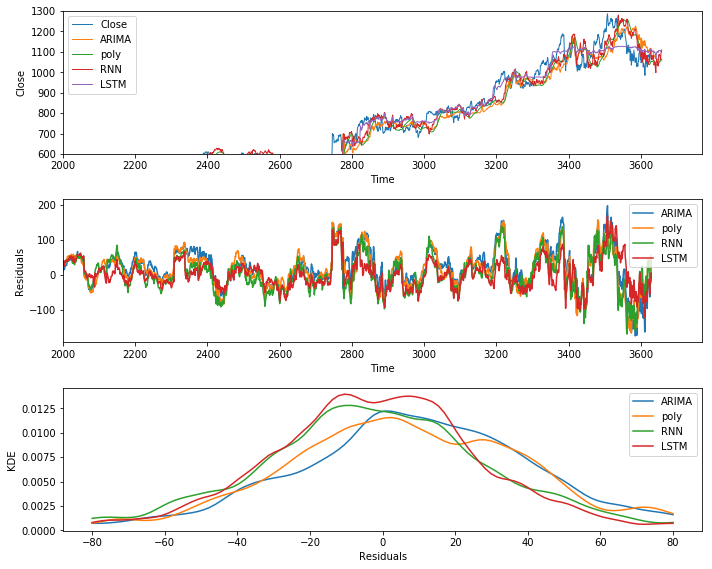

In [13]:
plot_results(results=resultsTotal, steps_ahead=steps_ahead, fit_range=fit_range, 
             xlim_lo=2000, xlim_hi=3770, ylim_lo=600, ylim_hi=1300, xres_lo=-80, xres_hi=80,
             lenSeries=len(series))

An average of the optimized predictions is also a prediction:

In [15]:
sigma2Total = 1/(1/sigma[0]**2 + 1/sigma[1]**2 + 1/sigma[2]**2 + 1/sigma[3]**2)
resultsTotal['average'] = (resultsTotal['ARIMA']/sigma[0]**2 + resultsTotal['poly']/sigma[1]**2 +
                           resultsTotal['RNN']/sigma[2]**2   + resultsTotal['LSTM']/sigma[3]**2)*sigma2Total
sigma.append( np.sqrt(mean_squared_error(
        resultsTotal.loc[(fit_range+steps_ahead-1):(len(series)-1),'Close'],
        resultsTotal.loc[(fit_range+steps_ahead-1):(len(series)-1),'average'])) )
print(sigma[-1])

37.05654744616955


The average prediction is not lower than the RMSE from the LSTM model. This indicates (and it can also be inferred from the residuals plot) that the predictions of the models are not statistically independent. If they were independent, the expected error would be:

In [16]:
print(np.sqrt(sigma2Total))

20.215214505196737


The final predictions are:

In [10]:
resultsTotal

,Index,Close,ARIMA,poly,RNN,LSTM,average
79,2004-12-10,85.910912,91.6124,82.791,104.558868,92.862923,93.7052
80,2004-12-13,85.310310,90.0358,84.7562,104.022583,92.654099,93.5921
81,2004-12-14,89.434433,98.1131,86.8874,107.306732,93.003403,96.7313
82,2004-12-15,89.979980,97.5751,88.8106,107.847649,92.913948,97.1591
83,2004-12-16,88.323326,90.8135,90.3968,106.028473,92.720551,95.5463
84,2004-12-17,90.130127,86.8142,91.518,103.751785,92.194839,94.1728
85,2004-12-20,92.602600,78.3221,91.7986,97.712532,90.266945,90.2243
86,2004-12-21,91.966965,80.0495,92.1601,97.105003,91.209511,90.7699
87,2004-12-22,93.243240,78.2377,92.2383,95.191109,90.399681,89.6372
88,2004-12-23,94.044044,77.9814,92.2249,93.519608,90.458672,89.1324
